<a href="https://colab.research.google.com/github/githyan/sentiment-analysis-Indonesia-president-election-2024/blob/main/Pilpres_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/dataset/pilpres/sentiment_dataset'
train_dir = os.path.join(path)
os.listdir(train_dir)

['0', '1', '2']

### Use the `train` directory to create both train and validationi datasets with split of 20% for `validation`

In [5]:
BATCH_SIZE = 32
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=BATCH_SIZE, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=BATCH_SIZE, validation_split=0.2,
    subset='validation', seed=seed)
test_ds = train_ds.concatenate(val_ds)
class_names = train_ds.class_names

Found 4130 files belonging to 3 classes.
Using 3304 files for training.
Found 4130 files belonging to 3 classes.
Using 826 files for validation.


### Load and take a look at a few text on review their labels

In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(1):
        print(label_batch[i].numpy(), text_batch.numpy()[1])

0 b'aku heran dengan mereka yg ribut soal capr wong pemilu aja belum tentu bisa digelar kok dunia sekarang lagi menuju ke perang dunia hitungannya bukan lagi bulan tapi jam kondisi darurat milit akan terjadi dihampir seluruh dunia'


### Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Text Preprocessing and Text Vectorization

In [8]:
def custom_standarization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]'% re.escape(string.punctuation), '')

vocab_size = 30000
sequence_length = 200

vectorize_layer = TextVectorization(
    standardize=custom_standarization,
    max_tokens=vocab_size,
    output_mode='int',
    # ngrams=3,
    output_sequence_length=sequence_length
)

text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


In [9]:
text, label = next(iter(train_ds))
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

first_review, first_label = text[0], label[0]
print("Review", first_review)
print("Label", class_names[first_label])
# print(pd.DataFrame(data=dict(tf_idf=[vectorize_text(first_review, first_label)]))
print("Vectorized review", vectorize_text(first_review, first_label))
# pd.DataFrame(data=dict(tf_idf=[vectorize_text(first_review, first_label)]))


Review tf.Tensor(b'ani vision berani menghadapi tantangan serta dengan ideidenya yang cemerlang mampu menjadi pemimpin berkualita', shape=(), dtype=string)
Label 0
Vectorized review (<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[   8,   26,  510,  547, 1103,  229,   20, 8226,    6, 2925,  281,
          63,   87, 1622,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

### Create a classification model

In [10]:
_dims = 20
def building_model(embedding_dims):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')
    vectorize_ = vectorize_layer(text_input)
    embedding = Embedding(vocab_size, embedding_dims, name='embedding')(vectorize_)

    net = Conv1D(32, 40, activation='relu', name='net_1')(embedding)
    net = Conv1D(64, 40, activation='relu', name='net_2')(net)
    net = Conv1D(128, 40, activation='relu', name='net_3')(net)
    net = GlobalAveragePooling1D()(net)
    net = Dense(1024, input_dim=sequence_length, activation='tanh', name='Fully_connected')(net)

    output = Dense(3, activation='softmax', name='output')(net)

    return tf.keras.Model(text_input, output)


model = building_model(embedding_dims=_dims)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 200, 20)           600000    
                                                                 
 net_1 (Conv1D)              (None, 161, 32)           25632     
                                                                 
 net_2 (Conv1D)              (None, 122, 64)           81984     
                                                                 
 net_3 (Conv1D)              (None, 83, 128)           327808    
                                                             

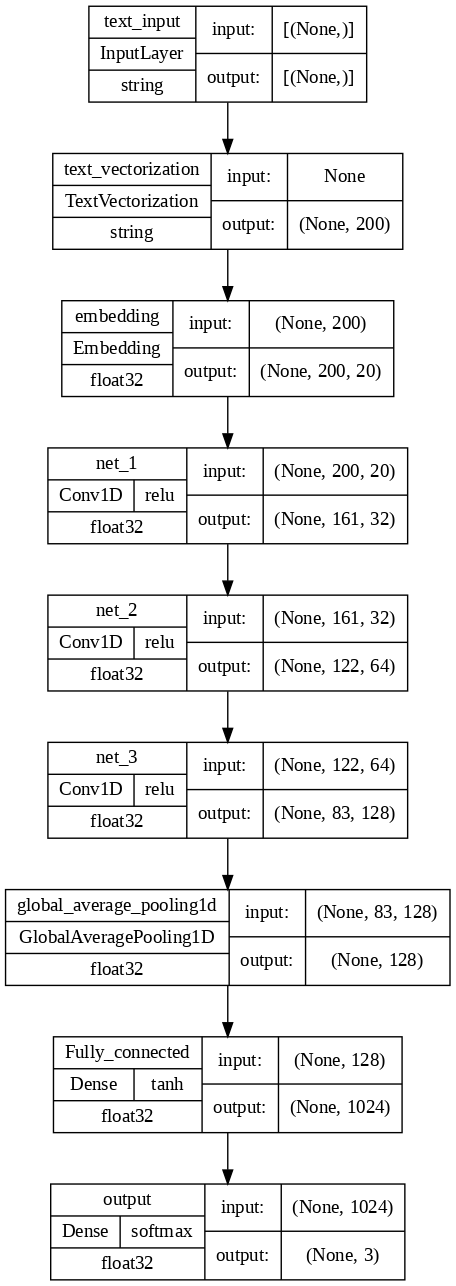

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True,
                          show_layer_activations=True,
                          show_layer_names=True,
                         show_dtype=True, dpi=100)

### Terminate Callbacks : terminating while training get value default > 0.9 from baseline

### using Cross Validation to training datasets

In [14]:
from sklearn.model_selection import KFold
import numpy as np
X_train = np.concatenate(list(train_ds.map(lambda x, y:x)))
X_labels = np.concatenate(list(train_ds.map(lambda x, y:y)))

y_val = np.concatenate(list(val_ds.map(lambda x, y: x)))
y_labels = np.concatenate(list(val_ds.map(lambda x, y: y)))

inputs = np.concatenate((X_train, y_val), axis=0)
targets = np.concatenate((X_labels, y_labels), axis=0)

on_folds = 1

fold_acc = []
fold_loss = []
val_fold_acc = []
val_fold_loss = []
epochs=20
skfold = KFold(n_splits=epochs, shuffle=True)
for train, test in skfold.split(inputs, targets):

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    print('-----------------------------------------------------')
    print(f'Training for fold {on_folds} ...')
    with tf.device('/GPU:0'):
        history = model.fit(inputs[train], targets[train],
                            validation_data=(inputs[test], targets[test]),
                            validation_batch_size=BATCH_SIZE)
        acc_scores = model.evaluate(inputs[train], targets[train], verbose=0)
        val_scores = model.evaluate(inputs[test], targets[test], verbose=0)
        fold_acc.append(acc_scores[1])
        fold_loss.append(acc_scores[0])

        val_fold_acc.append(val_scores[1])
        val_fold_loss.append(val_scores[0])
    on_folds += 1

-----------------------------------------------------
Training for fold 1 ...
123/123 [==============================] - 27s 153ms/step - loss: 1.0337 - accuracy: 0.5103 - val_loss: 1.1116 - val_accuracy: 0.4928
-----------------------------------------------------
Training for fold 2 ...
123/123 [==============================] - 14s 104ms/step - loss: 0.9506 - accuracy: 0.5802 - val_loss: 1.0116 - val_accuracy: 0.5507
-----------------------------------------------------
Training for fold 3 ...
123/123 [==============================] - 13s 93ms/step - loss: 0.7805 - accuracy: 0.6689 - val_loss: 0.7891 - val_accuracy: 0.6329
-----------------------------------------------------
Training for fold 4 ...
123/123 [==============================] - 13s 95ms/step - loss: 0.6500 - accuracy: 0.7181 - val_loss: 0.6146 - val_accuracy: 0.7101
-----------------------------------------------------
Training for fold 5 ...
123/123 [==============================] - 13s 90ms/step - loss: 0.5219 - ac

In [15]:
import pandas as pd
# for i in range(0, len(fold_acc)):
# on_epochs = range(0, len(fold_acc))
on_epochs = range(0, 20)
df = pd.DataFrame(data={
    'fold': [i + 1 for i in on_epochs],
    'Loss': [fold_loss[i] for i in on_epochs],
    'accuracy': [fold_acc[i] for i in on_epochs],
    'val_acc': [val_fold_acc[i] for i in on_epochs],
    'val_loss':[val_fold_loss[i] for i in on_epochs]
})
df

,fold,Loss,accuracy,val_acc,val_loss
0,1,1.055691,0.529697,0.492754,1.111644
1,2,0.817018,0.662248,0.550725,1.011612
2,3,0.629484,0.727759,0.632850,0.789084
3,4,0.522159,0.762682,0.710145,0.614551
4,5,0.394505,0.858527,0.748792,0.575837
5,6,0.325814,0.881468,0.826087,0.406943
6,7,0.254962,0.912057,0.850242,0.375708
7,8,0.199672,0.931175,0.893720,0.256481
8,9,0.161592,0.945705,0.908213,0.246057
9,10,0.125657,0.961509,0.956522,0.131739


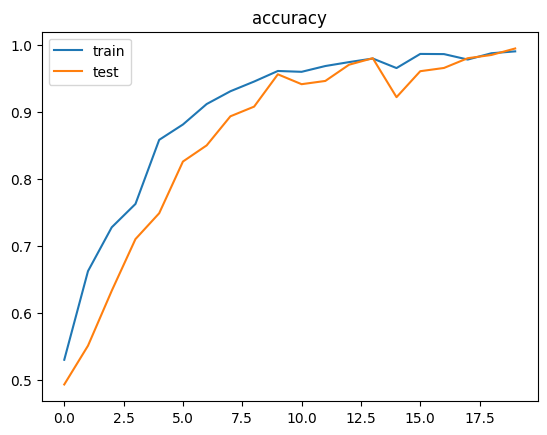

In [16]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
plt.title('accuracy')
plt.plot(df.accuracy, label='train')
plt.plot(df.val_acc, label='test')
# plt.grid()
plt.legend()
plt.show()

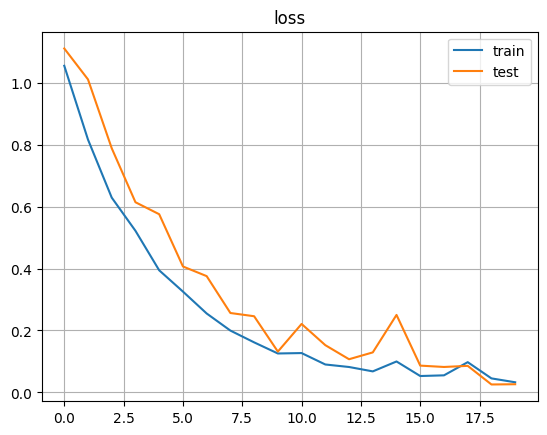

In [17]:
# import matplotlib.pyplot as plt
plt.title('loss')
plt.plot(df.Loss, label='train')
plt.plot(df.val_loss, label='test')
plt.grid()
plt.legend()
plt.show()

In [18]:
def eval(metrics):
    scores = model.evaluate(inputs[metrics], targets[metrics], verbose=0)
    print(f'Score for fold {on_folds - 1}: {model.metrics_names[1]} of {round(scores[1],2)}')
    print(f'Score for fold {on_folds - 1}: {model.metrics_names[0]} of {round(scores[0],2)}')
print('evaluate train')
eval(train)
print('evaluate val')
eval(test)

evaluate train
Score for fold 20: accuracy of 0.99
Score for fold 20: loss of 0.03
evaluate val
Score for fold 20: accuracy of 1.0
Score for fold 20: loss of 0.03


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def classification_result(ds, name:str):
    y_pred = []
    y_true = []
    for txt_batch, label_batch in ds:
        y_true.append(label_batch)
        y_pred.append(np.argmax(model.predict(txt_batch), axis=-1))

    corrected_labels = tf.concat([item for item in y_true],axis=0)
    predicted_labels = tf.concat([item for item in y_pred],axis=0)

    print(f'confusion matrix =>{name}')
    print(confusion_matrix(predicted_labels.numpy(), corrected_labels.numpy()))
    print(f'classification report =>{name}')
    print(classification_report(corrected_labels, predicted_labels, target_names=class_names))

classification_result(val_ds, name='validation')
classification_result(test_ds, name='test')
classification_result(train_ds, name='train')

1/1 [==============================] - 0s 444ms/step
confusion matrix =>validation
[[414   6   0]
 [  0 162   5]
 [  0   0 239]]
classification report =>validation
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       414
           1       0.97      0.96      0.97       168
           2       1.00      0.98      0.99       244

    accuracy                           0.99       826
   macro avg       0.99      0.98      0.98       826
weighted avg       0.99      0.99      0.99       826

1/1 [==============================] - 0s 32ms/step
confusion matrix =>test
[[2093   18    1]
 [   4  814   14]
 [   0    0 1186]]
classification report =>test
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2097
           1       0.98      0.98      0.98       832
           2       1.00      0.99      0.99      1201

    accuracy                           0.99      4130
   macro avg       0.99